
# Stock trading with Machine Learning

Machine learning can help you predict where the market is headed and make smarter trading decisions. With the right algorithms, you can classify the next day’s market movement into three simple categories:

- Market will rise: Take a long position.
- Market will fall: Take a short position.
- Market will move sideways: Don’t take a position.

Knowing the market’s direction allows you to pick the best times to buy and sell.

A key part of this process is **feature engineering**, where we create useful inputs for the machine learning model to analyze. For example, technical indicators—like trend, volume, momentum, or volatility—can be added as features to improve predictions. These indicators are calculated from price and volume data and provide valuable insights into market behavior.

In this case study, we’ll use machine learning models to predict whether the current signal is to buy or sell. We’ll also create additional indicators to make the predictions even more accurate. This approach helps turn raw market data into clear, actionable trading signals.

In [1]:
! pip install -q yfinance

In [2]:
!pip install -q quantstats

In [3]:
!pip install -q ta

In [4]:
!pip install -q catboost

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import quantstats as qs
import pandas_datareader as pdr
import ta
import warnings
warnings.filterwarnings('ignore')

In [6]:
#Loading NVIDIA stocks
Nvidia = yf.download('NVDA', end = '2024-12-10')

# Resetting the MultiIndex columns to a single level
Nvidia.columns = Nvidia.columns.get_level_values(0)
# Remove the index name
Nvidia.columns.name = None
Nvidia

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000
1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000
1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000
1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000
1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000
...,...,...,...,...,...,...
2024-12-03,140.250336,140.259995,140.539993,137.949997,138.259995,164414000
2024-12-04,145.130005,145.139999,145.789993,140.289993,142.000000,231224300
2024-12-05,145.059998,145.059998,146.539993,143.949997,145.110001,172621200


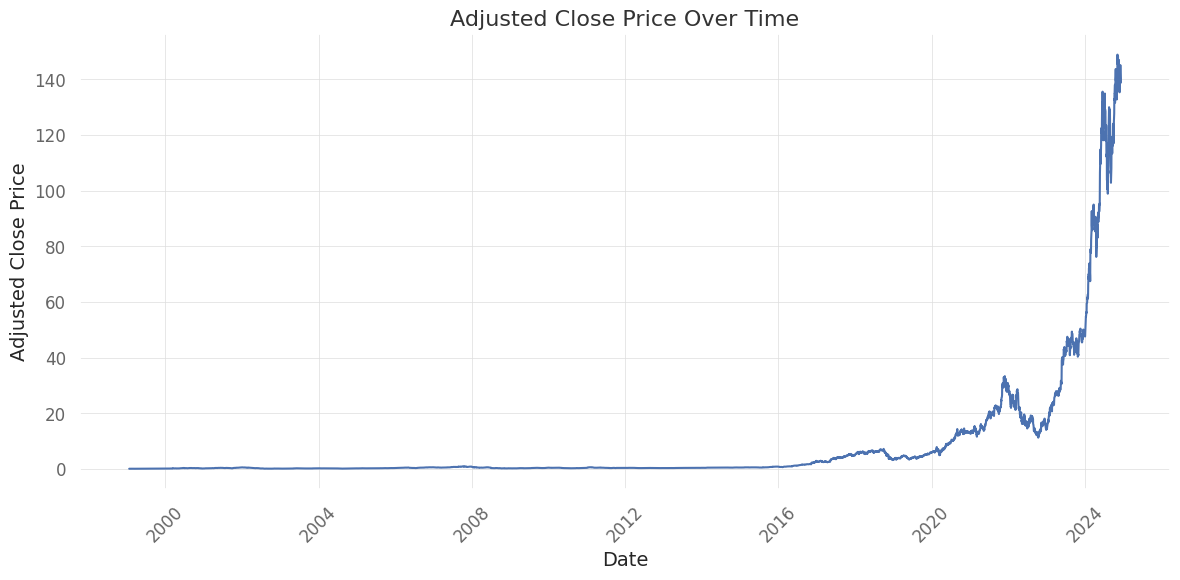

In [7]:
plt.figure(figsize=(12, 6))

plt.plot(Nvidia.index, Nvidia['Adj Close'])

# Customize the plot
plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
### splitting the data into train and test
train = Nvidia[Nvidia.index.year <= 2022]
test = Nvidia[Nvidia.index.year >= 2022]

#converting to a pandas dataframe
train = pd.DataFrame(train)
test = pd.DataFrame(test)





In [9]:
train.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000
1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000
1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000
1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000
1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000


In [10]:
test.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2022-01-03,30.070988,30.121000,30.711000,29.785000,29.815001,391547000
2022-01-04,29.241369,29.290001,30.468000,28.349001,30.277000,527154000
2022-01-05,27.558168,27.604000,29.416000,27.533001,28.948999,498064000
2022-01-06,28.131212,28.177999,28.438000,27.065001,27.639999,454186000
2022-01-07,27.201757,27.247000,28.422001,27.056999,28.141001,409939000


### Target variable creation
Lets first start by creating some other variables

**Close_Shift** which contains the previous day adjusted closing price. This practice is fairly common when dealing with time series data, and it's called lagging.

**daily returns** which is the percentage difference between today's closing price and yesterday's closing price.

- The variable target will receive binary values, either 0 or 1, according to either the daily return was higher or lower than 0. We are going to use Panda's shift( ) method to bring the values in target one row above the daily returns it was computed on. If the next day's returns are higher than zero, then target will be equal to 1, indicating that the next day was a bullish day. If the next day's returns are below zero, then the target variable will be equal to 0, indicating that the next day was a bearish day.

In [11]:
train['Close_Shift'] = train['Adj Close'].shift(1)
test['Close_Shift'] = test['Adj Close'].shift(1)

train['Return'] = (train['Adj Close'] - train['Close_Shift']) / train['Close_Shift']
test['Return'] = (test['Adj Close'] - test['Close_Shift']) / test['Close_Shift']

In [12]:
# Creating target variable on both datasets
train['target'] = np.where(train['Return'].shift(-1) > 0, 1, 0)
test['target'] = np.where(test['Return'].shift(-1) > 0, 1, 0)

In [13]:
train


,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,target
Date,,,,,,,,,
1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000,NaN,NaN,1
1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000,0.037615,0.104764,0
1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000,0.041556,-0.077593,0
1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000,0.038331,-0.003110,0
1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000,0.038212,-0.003144,0
...,...,...,...,...,...,...,...,...,...
2022-12-23,15.194948,15.206000,15.339000,14.883000,15.196000,349326000,15.327851,-0.008671,0
2022-12-27,14.110738,14.121000,15.100000,14.056000,15.074000,464902000,15.194948,-0.071353,0
2022-12-28,14.025798,14.036000,14.262000,13.884000,13.927000,351066000,14.110738,-0.006020,1


In [14]:
test

,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,target
Date,,,,,,,,,
2022-01-03,30.070988,30.121000,30.711000,29.785000,29.815001,391547000,NaN,NaN,0
2022-01-04,29.241369,29.290001,30.468000,28.349001,30.277000,527154000,30.070988,-0.027589,0
2022-01-05,27.558168,27.604000,29.416000,27.533001,28.948999,498064000,29.241369,-0.057562,1
2022-01-06,28.131212,28.177999,28.438000,27.065001,27.639999,454186000,27.558168,0.020794,0
2022-01-07,27.201757,27.247000,28.422001,27.056999,28.141001,409939000,28.131212,-0.033040,1
...,...,...,...,...,...,...,...,...,...
2024-12-03,140.250336,140.259995,140.539993,137.949997,138.259995,164414000,138.620453,0.011758,1
2024-12-04,145.130005,145.139999,145.789993,140.289993,142.000000,231224300,140.250336,0.034793,0
2024-12-05,145.059998,145.059998,146.539993,143.949997,145.110001,172621200,145.130005,-0.000482,0


In [15]:
X_train = train.drop('target', axis = 1)
y_train = train.target
X_test = test.drop('target', axis = 1)
y_test = test.target

## Feature engeneering


To increase the model's predicting ability, we must increase the amount of predictor variables to enhance the robustness of the model in performing its task.

The feature_engineering function below adds a bunch of different indicators that are going to increase the amount of independent features, which the model can learn from to identify relevant patterns to compute the probabilities of the target variable values.Some of the features are

- **Simple Moving Averages**: I'm going to add the SMAs for 5, 10, 15, 20, 30, 50, 80, 100, and 200 periods.

- **Relative Strength Index (RSI)**: A momentum indicator used to identify overbought and oversold price regions.

- **Bollinger Bands**: A volatility indicator that can also be used to identify oversold and overbought price regions.

- **Commodity Channel Index (CCI)**: A momentum indicator also used to identify overbought and oversold price regions.

- **On Balance Volume (OBV)**: A volume-based indicator used to measure buying and selling pressure. It is also used to identify potential divergences between price and volume, which may signal a trend reversal.

*other classical indicators*

- **Moving Average Ratios:** The Adjusted Close ÷ The Simple Moving Average.

- **RSI Overbought:** A binary feature that is going to be assigned the value of 1 if the RSI is above 70.

- **RSI Oversold:** A binary feature that is going to be assigned the value of 1 if the RSI is below 30.

- **Above BB High:** A binary feature that is going to be assigned the value of 1 if the Adj Close price is above the upper band of the Bollinger Bands.

- **Below BB Low:** A binary feature that is going to be assigned the value of 1 if the Adj Close price is below the lower band of the Bollinger Bands.

- **OBV Divergence 10 Days:** A feature that subtracts the sum of the differences of the OBV in the last ten days by the sum of the differences of the Adj Close prices in the last ten days.

- **OBV Divergence 20 Days:** A feature that subtracts the sum of the differences of the OBV in the last twenty days by the sum of the differences of the Adj Close prices in the last twenty days.

- **CCI High:** A binary feature that is going to be assigned the value of 1 if CCI is higher than 120.

- **CCI Low:** A binary feature that is going to be assigned the value of 1 if CCI is lower than -120.

- **Shorter Moving Average > Longer Moving Average:** A binary feature that is going to be assigned the value of 1 if a shorter moving average is above its immediate longer moving average, which indicates a higher trend in prices in that certain period.


In [16]:
# Defining feature engineering function
def feature_engineering(df):

    # Adding Simple Moving Averages
    df['sma5'] = ta.trend.sma_indicator(df['Adj Close'],window = 5)
    df['sma10'] = ta.trend.sma_indicator(df['Adj Close'],window = 10)
    df['sma15'] = ta.trend.sma_indicator(df['Adj Close'],window = 15)
    df['sma20'] = ta.trend.sma_indicator(df['Adj Close'],window = 20)
    df['sma30'] = ta.trend.sma_indicator(df['Adj Close'],window = 30)
    df['sma50'] = ta.trend.sma_indicator(df['Adj Close'],window = 50)
    df['sma80'] = ta.trend.sma_indicator(df['Adj Close'],window = 80)
    df['sma100'] = ta.trend.sma_indicator(df['Adj Close'],window = 100)
    df['sma200'] = ta.trend.sma_indicator(df['Adj Close'],window = 200)

    # Adding Price to Simple Moving Averages ratios

    df['sma5_ratio'] = df['Adj Close'] / df['sma5']
    df['sma10_ratio'] = df['Adj Close'] / df['sma10']
    df['sma20_ratio'] = df['Adj Close'] / df['sma20']
    df['sma30_ratio'] = df['Adj Close'] / df['sma30']
    df['sma50_ratio'] = df['Adj Close'] / df['sma50']
    df['sma80_ratio'] = df['Adj Close'] / df['sma80']
    df['sma100_ratio'] = df['Adj Close'] / df['sma100']
    df['sma200_ratio'] = df['Adj Close'] / df['sma200']

    # Adding RSI, CCI, Bollinger Bands, and OBV

    df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    bb_indicator = ta.volatility.BollingerBands(df['Adj Close'])
    df['bb_high'] = bb_indicator.bollinger_hband()
    df['bb_low'] = bb_indicator.bollinger_lband()
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'], volume=df['Volume']).on_balance_volume()

    # Adding features derived from the indicators above

    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int)
    df['above_bb_high'] = (df['Adj Close'] >= df['bb_high']).astype(int)
    df['below_bb_low'] = (df['Adj Close'] <= df['bb_low']).astype(int)
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(10).sum() - df['Adj Close'].diff().rolling(10).sum()
    df['obv_divergence_20_days'] = df['obv'].diff().rolling(20).sum() - df['Adj Close'].diff().rolling(20).sum()
    df['cci_high'] = (df['cci'] >= 120).astype(int)
    df['cci_low'] = (df['cci'] <= -120).astype(int)
    df['sma5 > sma10'] = (df['sma5'] > df['sma10']).astype(int)
    df['sma10 > sma15'] = (df['sma10'] > df['sma15']).astype(int)
    df['sma15 > sma20'] = (df['sma15'] > df['sma20']).astype(int)
    df['sma20 > sma30'] = (df['sma20'] > df['sma30']).astype(int)
    df['sma30 > sma50'] = (df['sma30'] > df['sma50']).astype(int)
    df['sma50 > sma80'] = (df['sma50'] > df['sma80']).astype(int)
    df['sma80 > sma100'] = (df['sma80'] > df['sma100']).astype(int)
    df['sma100 > sma200'] = (df['sma100'] > df['sma200']).astype(int)

    # Removing NaN values from the dataframe
    df.dropna(inplace = True)
    return df

In [17]:
# Applying function to the X_train and X_test sets
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [18]:
X_train.head()

,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,sma5,sma10,...,cci_high,cci_low,sma5 > sma10,sma10 > sma15,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200
Date,,,,,,,,,,,,,,,,,,,,,
1999-11-04,0.055765,0.060807,0.062370,0.057813,0.057813,1260336000,0.052422,0.063785,0.048624,0.044672,...,1,0,1,1,0,1,0,1,1,1
1999-11-05,0.053974,0.058854,0.063021,0.055990,0.062500,616368000,0.055765,-0.032118,0.050965,0.045950,...,1,0,1,1,1,1,0,1,1,1
1999-11-08,0.055527,0.060547,0.062240,0.055208,0.057031,470016000,0.053974,0.028766,0.053090,0.047586,...,1,0,1,1,1,1,0,1,1,1
1999-11-09,0.054690,0.059635,0.060677,0.057292,0.060417,272352000,0.055527,-0.015063,0.054476,0.048756,...,1,0,1,1,1,1,0,1,1,1
1999-11-10,0.054213,0.059115,0.059896,0.057943,0.059831,144048000,0.054690,-0.008720,0.054834,0.050069,...,0,0,1,1,1,1,0,1,1,1


In [19]:
X_test.head()

,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,sma5,sma10,...,cci_high,cci_low,sma5 > sma10,sma10 > sma15,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-18,11.955244,11.967,12.492,11.618,12.344,659362000,11.876320,0.006646,11.696898,12.009490,...,0,0,0,0,0,0,0,0,0,0
2022-10-19,12.039160,12.051,12.350,11.834,11.879,523131000,11.955244,0.007019,11.806989,11.893804,...,0,0,0,0,0,0,0,0,0,0
2022-10-20,12.182022,12.194,12.769,12.105,12.113,652398000,12.039160,0.011866,11.853743,11.800296,...,0,0,1,0,0,0,0,0,0,0
2022-10-21,12.453752,12.466,12.498,11.887,12.098,609494000,12.182022,0.022306,12.101299,11.839257,...,0,0,1,0,0,0,0,0,0,0
2022-10-24,12.586623,12.599,12.710,12.064,12.508,517457000,12.453752,0.010669,12.243360,11.932066,...,0,0,1,0,0,0,0,0,0,0


In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5827, 46), (539, 46), (6026,), (738,))

In [21]:
# Removing from y_train and y_test the NaN values that were dropped from X_train and X_test by the index
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5827, 46), (539, 46), (5827,), (539,))

# Modelling

In [23]:
! pip install -q xgboost

In [24]:
! pip install -q lightgbm

In [25]:
! pip install -q catboost

In [26]:
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Creating a list of different classification models
classifiers = [
    LogisticRegression(random_state = 42),
    XGBClassifier(random_state = 42,verbose = False),
    CatBoostClassifier(random_state = 42, verbose = False),
    AdaBoostClassifier(random_state = 42),
    RandomForestClassifier(random_state = 42)
]

#  Iteraring over classifiers in the list above, training, and evaluating them
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred)
    print(f'{type(clf).__name__}: AUC Score={auc_score:.3f}')

LogisticRegression: AUC Score=0.466
XGBClassifier: AUC Score=0.572
CatBoostClassifier: AUC Score=0.548
AdaBoostClassifier: AUC Score=0.508
RandomForestClassifier: AUC Score=0.585


It is important to note that the values of the  AUC score are very low and cannot be approved for production but because this is a learning notebook we can continue with our modelling.


 Model AUC Score = 0.585 



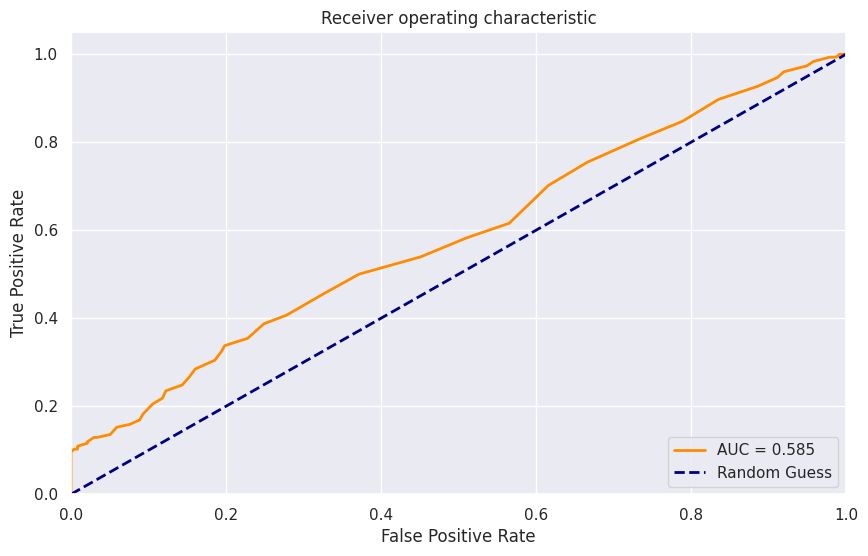

In [31]:
# Creating XGBClassifier Model
model = RandomForestClassifier(random_state = 42,verbose = False)

# Training and running predictions on the testing set
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_pred)
print(f'\n Model AUC Score = {auc_score:.3f} \n')

# Plotting AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
sns.set_theme(style='darkgrid')
plt.grid(True)
plt.show()

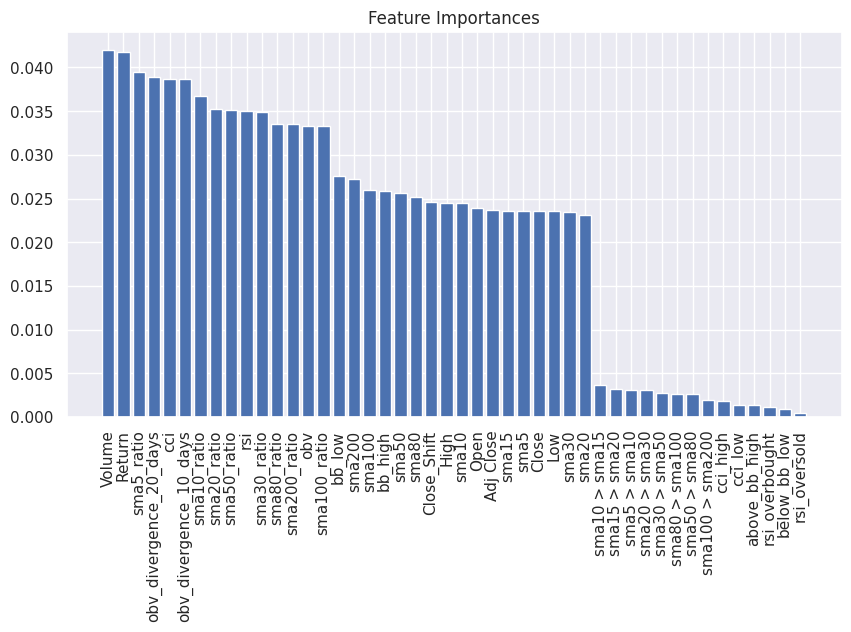

In [32]:
# Plotting Feature Importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.grid(True)
plt.show()

The model relied heavily on the Volume,return,cci and sma5_ratio

In [33]:
y_pred

array([0.85, 0.81, 0.82, 0.84, 0.77, 0.29, 0.79, 0.78, 0.29, 0.68, 0.33,
       0.77, 0.83, 0.84, 0.78, 0.36, 0.76, 0.62, 0.25, 0.67, 0.31, 0.28,
       0.27, 0.38, 0.82, 0.72, 0.34, 0.29, 0.33, 0.75, 0.78, 0.4 , 0.36,
       0.28, 0.73, 0.74, 0.41, 0.74, 0.82, 0.39, 0.41, 0.33, 0.25, 0.28,
       0.65, 0.28, 0.29, 0.34, 0.34, 0.81, 0.74, 0.43, 0.44, 0.48, 0.53,
       0.46, 0.63, 0.69, 0.62, 0.61, 0.58, 0.52, 0.5 , 0.49, 0.55, 0.44,
       0.47, 0.44, 0.45, 0.44, 0.42, 0.48, 0.48, 0.45, 0.45, 0.46, 0.41,
       0.44, 0.45, 0.38, 0.43, 0.46, 0.55, 0.49, 0.51, 0.45, 0.48, 0.57,
       0.53, 0.59, 0.47, 0.46, 0.5 , 0.53, 0.41, 0.4 , 0.57, 0.43, 0.52,
       0.45, 0.48, 0.47, 0.61, 0.58, 0.52, 0.56, 0.52, 0.61, 0.48, 0.47,
       0.51, 0.43, 0.46, 0.48, 0.51, 0.5 , 0.57, 0.57, 0.47, 0.53, 0.54,
       0.5 , 0.48, 0.47, 0.49, 0.55, 0.51, 0.48, 0.53, 0.52, 0.47, 0.41,
       0.49, 0.51, 0.51, 0.52, 0.55, 0.5 , 0.57, 0.48, 0.53, 0.5 , 0.55,
       0.43, 0.52, 0.4 , 0.25, 0.33, 0.32, 0.26, 0.

Our classifier gives us as output different probability values that range from 0.0 to 1.0. Generally, people would consider that any value below 0.5 would indicate a selling opportunity, while any value above that threshold would indicate a buying opportunity.

We can, however, create a strategy that is more robust than that.

I'm going to divide the values in the y_pred array in eight different classes according to their percentile ranks. The first class will include values that are equal or less than the 12.5ᵗʰ percentile, then the second will include values between the 12.5ᵗʰ percentile and 25ᵗʰ percentile, and so on.

After this is done, I'll create a table that will display the frequency count of true labels for each percentile group of the values in y_pred. With this information, we can find the different ranges of probabilities that were mostly predictive for bullish and bearish days in the training set, and work with these specific ranges to develop a trading strategy.

In [34]:
quantile_intervals = np.arange(0, 1.125, 0.125) # Creating intervals for the quantiles
quantile_values = np.quantile(y_pred, quantile_intervals) # Dividing y_pred in 8 different quantiles
classes = pd.cut(y_pred, quantile_values) # Grouping probabilities according to the quantiles
X_test['y_true'] = y_test # Creating a new column in the X_test set containing the true label values
table = pd.crosstab(classes, X_test['y_true']) # Creating a table counting true labels according to each probability range
table

y_true,0,1
row_0,,
"(0.15, 0.25]",38,31
"(0.25, 0.28]",40,43
"(0.28, 0.3]",24,42
"(0.3, 0.33]",46,35
"(0.33, 0.35]",22,28
"(0.35, 0.41]",25,34
"(0.41, 0.5]",23,41
"(0.5, 0.85]",18,48


Typically, probabilities below 0.5 are seen as indicators of bearish days (days when stock prices are likely to go down). However, from the table, we notice an interesting pattern. In the probability range of (0.25, 0.28), there were 43 bullish days compared to 40 bearish days. This means the model was better at predicting bullish days in this range, even though the probabilities were below 0.5.

Using this insight, we can create a trading strategy:

- Sell (short sell) stocks whenever the model predicts probabilities in ranges where there are more bearish days. This suggests stock prices are likely to drop.
- Buy stocks whenever the model predicts probabilities in ranges with more bullish days.

This indicates stock prices are likely to rise.
By analyzing the probability ranges and their relationship to actual stock performance, we can make smarter, data-driven trading decisions.

In [35]:
# Initialize signals array
signals = np.zeros_like(y_pred)  # Create an array of zeros with the same length as y_pred

# Assign sell signals (-1) for ranges with more bearish days (y_true=0)
signals[(y_pred > 0.15) & (y_pred <= 0.25)] = -1  # 38 > 31
signals[(y_pred > 0.3) & (y_pred <= 0.33)] = -1   # 46 > 35

# Assign buy signals (1) for ranges with more bullish days (y_true=1)
signals[(y_pred > 0.25) & (y_pred <= 0.28)] = 1  # 43 > 40
signals[(y_pred > 0.28) & (y_pred <= 0.3)] = 1   # 42 > 24
signals[(y_pred > 0.33) & (y_pred <= 0.35)] = 1  # 28 > 22
signals[(y_pred > 0.35) & (y_pred <= 0.41)] = 1  # 34 > 25
signals[(y_pred > 0.41) & (y_pred <= 0.5)] = 1   # 41 > 23
signals[(y_pred > 0.5) & (y_pred <= 0.85)] = 1   # 48 > 18






[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.
 -1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1.
  1.  1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.
  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.
  1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1

In [36]:
X_test['sign'] = signals # Creating new column

In [37]:
X_test.head()

,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,sma5,sma10,...,sma5 > sma10,sma10 > sma15,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200,y_true,sign
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-18,11.955244,11.967,12.492,11.618,12.344,659362000,11.876320,0.006646,11.696898,12.009490,...,0,0,0,0,0,0,0,0,1,1.0
2022-10-19,12.039160,12.051,12.350,11.834,11.879,523131000,11.955244,0.007019,11.806989,11.893804,...,0,0,0,0,0,0,0,0,1,1.0
2022-10-20,12.182022,12.194,12.769,12.105,12.113,652398000,12.039160,0.011866,11.853743,11.800296,...,1,0,0,0,0,0,0,0,1,1.0
2022-10-21,12.453752,12.466,12.498,11.887,12.098,609494000,12.182022,0.022306,12.101299,11.839257,...,1,0,0,0,0,0,0,0,1,1.0
2022-10-24,12.586623,12.599,12.710,12.064,12.508,517457000,12.453752,0.010669,12.243360,11.932066,...,1,0,0,0,0,0,0,0,1,1.0


Whenever sign = 1, we buy the stock, expecting its price to go up the next day. Similarly, when sign = -1, we short sell the stock, expecting its price to go down the next day.

- We'll create a variable called position to represent whether we are buying or selling stocks each day based on the signal (sign) from the previous day.
- We'll also create a column called model_returns, which calculates profits or losses by multiplying the current position by the stock's daily return. This will show how well our strategy worked, depending on whether the day was bullish or bearish.


In [38]:
X_test['position'] = X_test['sign'].shift(1) # Creating 'position' attribute
X_test['model_returns'] = X_test['position'] * X_test['Return'] # Creating 'daily returns' attribute for the strategy

In [39]:
X_test.head(15)

,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,sma5,sma10,...,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200,y_true,sign,position,model_returns
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-18,11.955244,11.967,12.492,11.618,12.344,659362000,11.876320,0.006646,11.696898,12.009490,...,0,0,0,0,0,0,1,1.0,NaN,NaN
2022-10-19,12.039160,12.051,12.350,11.834,11.879,523131000,11.955244,0.007019,11.806989,11.893804,...,0,0,0,0,0,0,1,1.0,1.0,0.007019
2022-10-20,12.182022,12.194,12.769,12.105,12.113,652398000,12.039160,0.011866,11.853743,11.800296,...,0,0,0,0,0,0,1,1.0,1.0,0.011866
2022-10-21,12.453752,12.466,12.498,11.887,12.098,609494000,12.182022,0.022306,12.101299,11.839257,...,0,0,0,0,0,0,1,1.0,1.0,0.022306
2022-10-24,12.586623,12.599,12.710,12.064,12.508,517457000,12.453752,0.010669,12.243360,11.932066,...,0,0,0,0,0,0,1,1.0,1.0,0.010669
2022-10-25,13.247972,13.261,13.300,12.664,12.694,505482000,12.586623,0.052544,12.501906,12.099402,...,0,0,0,0,0,0,0,1.0,1.0,0.052544
2022-10-26,12.883332,12.896,13.388,12.708,12.869,532953000,13.247972,-0.027524,12.670740,12.238865,...,0,0,0,0,0,0,1,1.0,1.0,-0.027524
2022-10-27,13.163055,13.176,13.838,13.122,13.630,583113000,12.883332,0.021712,12.866947,12.360345,...,0,0,0,0,0,0,1,1.0,1.0,0.021712
2022-10-28,13.820410,13.834,13.850,13.061,13.104,521040000,13.163055,0.049939,13.140279,12.620789,...,0,0,0,0,0,0,0,1.0,1.0,0.049939


- By calculating the daily returns for our strategy, we can review the last four years and determine the cumulative returns from both the stock's performance overall and our strategy. This allows us to compare a simple Buy & Hold strategy (holding the stock without trading) to our model-driven approach to see which one would have provided higher returns over the past four years.

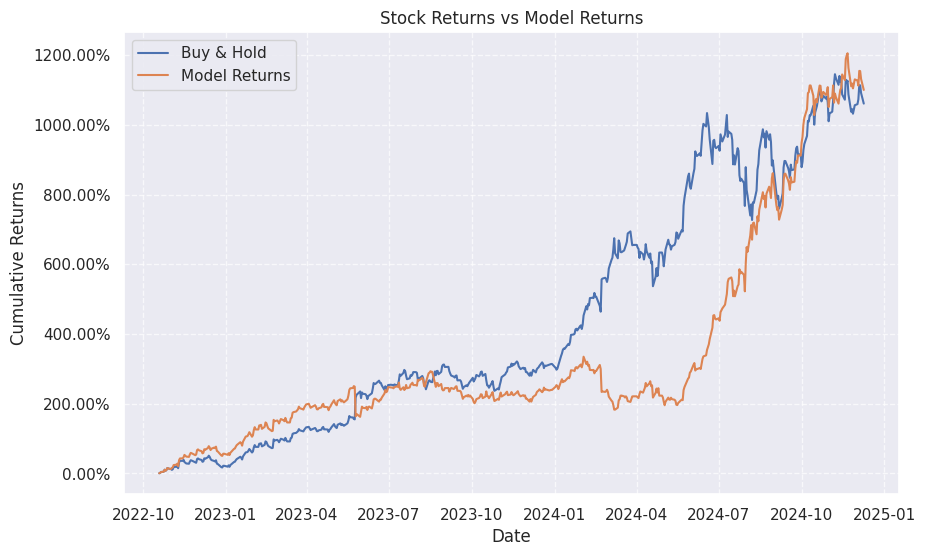

Buy & Hold Cumulative Returns = 1061.08%
Model Cumulative Returns = 1100.24%


In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd  # Assuming pandas is needed for X_test

# Drop NaN values to avoid errors
X_test = X_test.dropna(subset=['Return', 'model_returns'])

# Computing Buy & Hold Cumulative Returns
buy_and_hold_total_returns = (1 + X_test['Return']).cumprod()
buy_and_hold_total_returns = (buy_and_hold_total_returns - 1) * 100  # Convert to percentages

# Computing Model Cumulative Returns
model_cumulative_returns = (1 + X_test['model_returns']).cumprod()
model_cumulative_returns = (model_cumulative_returns - 1) * 100  # Convert to percentages


# Plotting line plot comparing Buy & Hold and Model
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(buy_and_hold_total_returns, label='Buy & Hold')
ax.plot(model_cumulative_returns, label='Model Returns')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Stock Returns vs Model Returns')

# Adding a '%' sign to the y-axis ticks
def percent_formatter(x, pos):
    return f'{x:.2f}%'
ax.yaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter))

plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()

# Printing results
if not buy_and_hold_total_returns.empty:
    print(f"Buy & Hold Cumulative Returns = {buy_and_hold_total_returns.iloc[-1]:.2f}%")
    print(f"Model Cumulative Returns = {model_cumulative_returns.iloc[-1]:.2f}%")
else:
    print("No data available for returns calculation.")


The line plot above shows a comparison of the performance of a simple Buy & Hold strategy versus a strategy based on the predictions generated by our model.

It is evident that, over time, the model-based strategy outperformed the Buy & Hold approach. However, there were some periods where the Buy and Hold approach performed better than the model.

In [ ]:
# # Comparing Strategy to the Benchmark (Buy & Hold during the same period)
# qs.reports.full(model_returns, benchmark =Nvidia_returns)

In [45]:
model_returns = X_test['model_returns']
Nvidia_returns = X_test['Return']


In [46]:
qs.reports.metrics(model_returns, benchmark =Nvidia_returns)

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2022-10-19   2022-10-19
End Period          2024-12-09   2024-12-09
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   1,061.08%    1,100.24%
CAGR﹪              120.37%      122.74%

Sharpe              2.47         2.52
Prob. Sharpe Ratio  100.0%       99.97%
Sortino             4.4          3.81
Sortino/√2          3.11         2.7
Omega               1.56         1.56

Max Drawdown        -27.05%      -34.88%
Longest DD Days     114          155

Gain/Pain Ratio     0.54         0.56
Gain/Pain (1M)      7.22         6.79

Payoff Ratio        1.18         1.18
Profit Factor       1.54         1.56
Common Sense Ratio  1.93         2.02
CPC Index           1.02         1.1
Tail Ratio          1.25         1.3
Outlier Win Ratio   3.3          3.51
Outlier Loss Ratio  3.23         3.0

MTD                 0.41%        -2.46%
3M         

This table compares the performance of a benchmark and a strategy over a two-year period. Both show impressive cumulative returns, with the strategy achieving 1,100.24% compared to the benchmark’s 1,061.08%, and slightly higher annualized growth (CAGR of 122.74% vs. 120.37%). While the strategy has better risk-adjusted metrics like the Sharpe ratio (2.52 vs. 2.47) and a higher Profit Factor (1.56 vs. 1.54), it also experienced deeper maximum drawdowns (-34.88% vs. -27.05%) and longer recovery periods. Notably, the strategy outperformed significantly in shorter timeframes, with a 6-month return of 200.37% versus the benchmark's 14.85%, indicating its potential for high growth despite higher risk. Overall, the strategy edges out the benchmark with stronger returns but at the cost of greater volatility.

# Conclusion
The model we have built above is just an initial approach, and there are still many potential improvements to be made. Using libraries for hyperparameters tuning could give us a higher-performing model, as well as feature selection to only use the most relevant features as predictors.
